# Below is with Generic Likelihood Model Class

In [156]:
import os, csv, random, time
from __future__ import division
from matplotlib import  pyplot as plt
import numpy as np
from scipy.stats import bernoulli,poisson,norm,expon
import scipy.io as sio
from scipy import stats
from collections import deque
from scipy import optimize
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

1. The function $regularized\_vector$ is what Nihar proposed. 

Suppose $w^*$ is the true value and $\hat{w}$ is the inferred value from our optimization, we want to minimize $||w^* - a \cdot \hat{w} - b||_2^2 $ by finding optimial value of a and b, which will be done through $matching\_func$. And then we introduce a new value $v= a\cdot \hat{w} + b$ as the new weight for the videos. 

All the error metric evaluation would be made between $v$ and $w^*$, and here we are using $L_2$ norm, which is assessed through $performance_nihar$

2. The function $performance\_isabelle$ is what Isabelle proposed.

Assume 3 scores $T_1, T_2, T_3$, that are adjacent when we rank all true scores, and the results scores of the corresponding videos $R_1, R_2, R_3$. We can compute $||\frac{T_2-T_1}{T_3-T_1+\epsilon}  - \frac{R_2-R_1}{R_3-R_1+\epsilon} ||$ and average over all adjacent triplets.

In [157]:
class Pairwise(GenericLikelihoodModel):
    
    def __init__(self, endog, video_num, video_score, exog=None, **kwds):
        super(Pairwise, self).__init__(endog, exog, **kwds)
        self.rank =  deque([[1],[1]])
        self.w_hat = []
        self.video_num = video_num
        self.pairs_truth = self.endog
        self.total_pairs = len(self.endog)
        self.v = []
        self.w_star = np.array(video_score)
        
     
    def test_data_generation_sparsity(self, showResult=False, Nihar=False, Isabelle=False):
        
        """
        Shows how the error evolves with sparser data
        """
        
        all_data = self.endog
        
        num_test_pairs = (np.array((1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1))* self.total_pairs).astype(int)
        
        output_error = []

        for test_pair_num in num_test_pairs:
            print 'Current evaluating with %d test pairs' % test_pair_num
            test_pairs = [self.pairs_truth[i] for i in random.sample(range(self.total_pairs), test_pair_num)]
            self.endog = np.array(test_pairs)
            
            w_init = np.random.uniform(-5,5,video_num)
            self.fit(w_init)
            
            if showResult:
                res = self.rank[0]
                compare_rank(self.w_star, res, False, True)
                plt.legend([str(i) for i in num_test_pairs])  
            if Nihar:
                output_error.append(self.performance_nihar())
            if Isabelle:
                output_error.append(self.performance_isabelle())
            
        self.endog = all_data
        return output_error
        
        
    def test_data_generation_noise(self, showResult=False, Nihar=False, Isabelle=False):
        """
        Generate a decision of whether to flip, using a percentage and then select randomly to flip
        """
        all_data = self.endog

        num_test_pairs = self.total_pairs
        flip_threshold = np.array((0,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5))
        
        output_error = []

        for to_flip in flip_threshold:
            print 'Current evaluating with %f to flip' % to_flip

            test_pairs_with_error = self.pairs_truth

            num_to_flip = int(num_test_pairs*to_flip)

            for i in random.sample(range(num_test_pairs), num_to_flip):
                test_pairs_with_error[i] = (self.pairs_truth[i][1],self.pairs_truth[i][0])

            self.endog = test_pairs_with_error
            
            w_init = np.random.uniform(-5,5,video_num)
            self.fit(w_init)

            if showResult:
                res = self.rank[0]
                compare_rank(self.w_star, res, False, True)
                plt.legend([str(i) for i in num_test_pairs])  
            if Nihar:
                output_error.append(self.performance_nihar())
            if Isabelle:
                output_error.append(self.performance_isabelle())
                
        self.endog = all_data
        return output_error
    
    
    def noise_generation(self, pair):
        """
        Generate a decision of whether to flip, using proability from normal distribution and then 
        Bernoulli to decide whether to flip
        """

        difference = self.rank[0][pair[0]] - self.rank[0][pair[1]]
        p = norm(0, 3.33).pdf(difference)
        decision = bernoulli.rvs(p,size=1)
        
        return decision
        
    
    
    def test_data_generation_noise_generative_model(self, showResult=False, Nihar=False, Isabelle=False):
        """
        Function that calculate error using normal distribution to determine the probility of whether to
        flip the pair. Highest chance, at scores equal is around 0.12
        """
        all_data = self.endog

        test_pairs = self.pairs_truth
        
        for i in range(self.total_pairs):
            if self.noise_generation(test_pairs[i]):
                test_pairs[i][0] = test_pairs[i][1]
                test_pairs[i][1] = self.pairs_truth[i][0]
                
        self.endog = test_pairs
        w_init = np.random.uniform(-5,5,video_num)
        self.fit(w_init)

        if showResult:
            res = self.rank[0]
            compare_rank(self.w_star, res, False, True)
            plt.legend([str(i) for i in num_test_pairs])  
        if Nihar:
            print self.performance_nihar()
        if Isabelle:
            print self.performance_isabelle()

        self.endog = all_data
        
    def nloglikeobs(self, params):
        """
        Calculate negative log likelihood used for main optimization
        """
        
        out = 1
        pairs = self.endog
        w = params
        
        for pair in pairs:
            out *= 1/(1+np.exp(w[pair[1]] - w[pair[0]]))   
            
        return -np.log(out)
    
    
    def score(self, params):
        """
        Calculate gradient
        """
        self.rank.popleft()
        w = params
        pairs = self.endog
        grad = []
        for i in range(len(w)):
            grad.append(self.calc_gradient(pairs, w, i))
        
        self.rank.append(grad)
        
        return np.array(grad)
    
        
    def calc_gradient(self,pairs, w, w_i):
        """
        Function used in score() to calculate gradient
        """
        gradient = 0

        for pair in pairs:
            if w_i == pair[0]:
                out = -1
            elif w_i == pair[1]:
                out = 1  
            else:
                out = 0

            gradient -= out / (1/(np.exp(w[pair[1]]-w[pair[0]]) + 0.00001) +1 )
            
        return gradient
    
    
    def matching_func(self, param):
        """
        Function used to calculate L2 norm of v and w_star. Used to find a and b.
        Here params is [a, b]
        """
        return np.linalg.norm(self.w_star - param[0]*np.array(self.rank[0]) - param[1])

    
    def regularized_vector(self):
        """
        Function used to generate vector v after using matching_func to find optimal a and b
        """
        coeff = optimize.minimize(self.matching_func, [0, 0])
        
        self.a = coeff['x'][0]
        self.b = coeff['x'][1]
        self.v = self.a*np.array(self.rank[0])+self.b
        
        
    def performance_isabelle(self):
        """
        Performance evaluation using method proposed by Isabelle
        """
        epsilon = 0.0001
        error = 0
        self.w_hat = np.array(self.rank[0])
        
        for i in range(len(self.w_star)-2):
            error += np.abs((self.w_star[i+1]-self.w_star[i])/(self.w_star[i+2]-self.w_star[i]+epsilon)-
                            (self.w_hat[i+1]-self.w_hat[i])/(self.w_hat[i+2]-self.w_hat[i]+epsilon))
        error /= self.total_pairs-2
        return error
    

    def performance_nihar(self):
        """
        Performance evaluation using method proposed by Nihar
        """
        self.regularized_vector()
        return np.linalg.norm(self.w_star - self.v)
    
    
    
    def fit(self, start_params=None, maxiter=1000, maxfun=5000):  
        return super(Pairwise, self).fit(start_params=start_params, 
                                         method='newton',
                                         maxiter=maxiter,
                                         disp=0,
                                         maxfun=maxfun)

# Generate Data randomly

In [81]:
def compare_rank(video_score, results, verbose=False, hist=False, pct=100):
    true_order = np.array(video_score).argsort()
    true_ranks = true_order.argsort()

    temp_o = np.array(results).argsort()
    temp_r = temp_o.argsort()

    resolution = 0.1
    video_score_results = np.round(np.array(results)/resolution)*resolution
    
    if verbose:
        print 'Result Order \t True Order \t Result Score \t Ture Score'
        for i in range(len(temp_r)):
            print temp_r[i], '\t\t', true_ranks[i], '\t\t', video_score_results[i], '\t\t', video_score[i]
            
    if hist:
        diff = np.abs(temp_r - true_ranks)
        plt.hist(diff, alpha=0.5)

In [82]:
video_num = 30

video_score = np.random.uniform(-5,5,video_num)
resolution = 0.1
video_score = np.round(video_score/resolution)*resolution

pairs_truth = []

for i in range(len(video_score)-1):
    for j in range(i+1, len(video_score)):
        if video_score[i] > video_score[j]:
            pairs_truth.append((i,j))
        else:
            pairs_truth.append((j,i))
            
total_pairs = len(pairs_truth)

In [114]:
model = Pairwise(np.array(pairs_truth), video_num, video_score)

w_init = np.ones(video_num)

# start_time = time.time()
# results = model.fit(w_init)
# print  'Time Spent: %.2f seconds' %float(time.time() - start_time)

In [97]:
res = model.rank[0]
compare_rank(video_score, res, True)

Result Order 	 True Order 	 Result Score 	 Ture Score
23 		23 		17.0 		2.8
4 		4 		-22.0 		-4.5
20 		21 		11.0 		1.1
21 		20 		13.0 		1.1
2 		1 		-24.0 		-4.9
18 		18 		7.0 		0.4
17 		17 		5.0 		0.3
11 		11 		-7.0 		-1.5
28 		27 		26.0 		4.5
24 		24 		20.0 		4.0
7 		7 		-15.0 		-3.4
29 		28 		28.0 		4.8
22 		22 		15.0 		1.7
26 		26 		24.0 		4.2
27 		29 		24.0 		4.8
14 		15 		-1.0 		-0.9
9 		9 		-11.0 		-2.0
5 		5 		-20.0 		-4.2
0 		0 		-28.0 		-4.9
13 		13 		-3.0 		-1.1
16 		16 		3.0 		-0.4
8 		8 		-13.0 		-3.1
19 		19 		9.0 		0.8
25 		25 		22.0 		4.0
15 		14 		1.0 		-0.9
6 		6 		-17.0 		-3.5
1 		2 		-26.0 		-4.7
10 		10 		-9.0 		-1.8
12 		12 		-5.0 		-1.4
3 		3 		-24.0 		-4.6


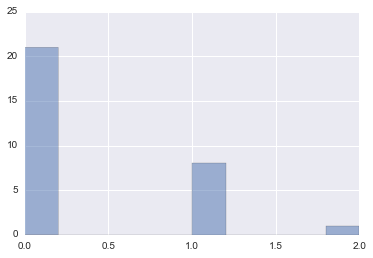

In [98]:
compare_rank(video_score, res, False, True)

Current evaluating with 435 test pairs
11.8306237069
Current evaluating with 348 test pairs
12.0092353184


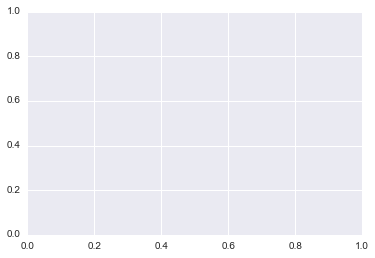

In [121]:
model = Pairwise(np.array(pairs_truth), video_num, video_score)

model.test_data_generation_sparsity(Nihar=True)

In [141]:
model = Pairwise(np.array(pairs_truth), video_num, video_score)

print model.test_data_generation_noise(Nihar=True)

Current evaluating with 0.000000 to flip
12.8717507997
Current evaluating with 0.050000 to flip
13.5408215565
Current evaluating with 0.100000 to flip
12.7329465414
Current evaluating with 0.150000 to flip
15.2905758874
Current evaluating with 0.200000 to flip
16.3992519058
Current evaluating with 0.250000 to flip
16.7115047844
Current evaluating with 0.300000 to flip
17.3488158498
Current evaluating with 0.400000 to flip
17.2909803597
Current evaluating with 0.500000 to flip
17.316969192
None


In [ ]:
model = Pairwise(np.array(pairs_truth), video_num, video_score)
w_init = np.ones(video_num)
model.fit(w_init)

In [ ]:
print model.test_data_generation_noise_generative_model(Nihar=True)
